$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [10]:
include("fanote_init.jl")

# Chapter 1: Introduction

## Section 1.1: What is the problem?

Solving nonlinear equations is part of almost all simulations of
physical processes. Physical models that are expressed as
nonlinear partial differential equations, for example, become
large systems of nonlinear equations when discretized. Developers of
simulation codes must either use a nonlinear solver as a tool or
write one from scratch. One purpose of this book is to show
these developers what technology is available, sketch the implementation,
and warn of the problems. We do this via algorithmic outlines,
nonlinear solvers in Julia that can be used for
production work, a suite of example problems, an IJulia notebook,
and chapter-ending projects.

We use the standard notation 

\begin{equation}
\mf(\vx) = 0
\end{equation}

for systems of $N$ equations in $N$ unknowns. We will refer to this as the
__nonlinear equations formulation__.
Here $\mf: \Omega   \to R^N$ where $\Omega \subset R^N$ is a open set.
We will call $\mf$ the
__nonlinear residual__
 or simply the __residual__.
Rarely can the solution of a nonlinear equation be given by
a closed-form expression, so iterative methods must be used
to approximate the solution numerically.
The output of an iterative method
is a sequence of approximations to a solution.

The __fixed-point__ formulation of a nonlinear equation is

$$
\vx = \mg(\vx) .
$$

The difference between the two formulations is not simply a matter of replacing
$\mf(\vx)$ by $\vx - \mg(\vx)$. The algorithms for $\mf(\vx) = 0$ take
a very different approach from those for fixed-point prolbems.

We will spend
most of our time in this introductory section on methods for the nonlinear equations formulation.
The reason for this is that much of the theory can be explored in the
simple context of scalar equations. We will consider fixed-point problems
seriously in [Chapter 4](SIAMFANLCh4.ipynb).



### Section 1.1.1: Notation


In this book, following the convention in 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>
and
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>,
vectors are to be understood as column vectors.
Following
<cite data-cite="ctk:acta"><a href="siamfa.html#ctk:acta">(Kel18)</cite>
denote vectors by boldfaced lower case letters
and matrices by boldfaced upper case letters,
for example $\vx$  and $\ma$. We denote the $i$th component of $\vx$
by $x_i$ to distinguish between the $i$th member of a sequence of
vectors $\vx_i$. We denote the $ij$ entry of $\ma$ by $\ma_{ij}$.

The vector
$\vx^*$ will denote a solution, $x$ a potential solution,
and $\{ \vx_n \}_{n \ge 0}$ the sequence of iterates. We will refer to
$\vx_0$ as the
\index{Initial!guess}
\index{Initial!iterate}{\bf initial iterate (not guess!)}.
We will denote
the $i$th component of a vector
$\vx_n$ from a sequence by $x_{ni}$. We will rarely need
to refer to individual components of vectors.
We will let
$\partial \mf/\partial x_i$ denote the partial derivative of $\mf$
with respect to
$x_i$. As is standard
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
$\ve = \vx - \vx^*$ will denote the error. So, for example,
$\ve_n = \vx_n - \vx^*$ is the error in the $n$th iterate.
    
If the components of $\mf$ are differentiable at $\vx \in R^N$,
we define the __Jacobian matrix__
$\mf'(\vx)$ by
    
$$
\mf'(\vx)_{ij} = \frac{\partial f_i}{\partial x_j} (\vx).
$$
Throughout the book, $\| \cdot \|$ will denote the Euclidean norm
on $R^N$:
    
$$
\| \vx \| = \left( \sum_{i=1}^N x_i^2 \right)^{1/2}.
$$


We treat scalar equations with lowercase letters. So a scalar equation
is $f(x) = 0$ and the derivative is $f'(x)$.
Many of the essential ideas in this book can be illustrated with scalar
equations and we do that in this chapter. The exception is the need to
solve linear systems of equations and linear least squares problems, which
will be the focus of the remaining chapters in the book.
The Julia codes for the examples in this section are in the
[src/Chapter1](src/Chapter1)
directory for the notebook. The solvers and
test problems are part of the [SIAMFANLEquations](https://github.com/ctkelley/NotebookSIAMFANL) Julia package.
    


## Section 1.2: Newton's Method

Most of the methods in this book are variations of Newton's method.
The exception will be Anderson acceleration, a solver for fixed-point problems, which we cover in
[Chapter 4](SIAMFANLCh4.ipynb).

The Newton sequence is

$$
\vx_{n+1} = \vx_n - \mf'(\vx_n)^{-1} \mf(\vx_n).
$$

The interpretation of the formula for the Newton iteration is that
we model $\mf$ at the current iterate $\vx_n$ with a linear
function
$$
\mm_n(x) = \mf(\vx_n) + \mf'(\vx_n) (\vx - \vx_n)
$$
and let the root of $\mm_n$ be the next iteration.
$\mm_n$ is called the
__local linear model__.
If $\mf'(\vx_n)$ is
nonsingular, then the Newton sequence is the solution of $\mm_n(\vx_{n+1}) = 0$.

We illusrate  the local linear model and the
Newton iteration for the scalar equation
$$
\arctan(x) = 0
$$
with initial iterate $x_0 = 1$. We graph the local linear model
$$
m_j(x) = f(x_j) + f'(x_j) (x - x_j)
$$
at $x_j$ from the point $(x_j, y_j) = (x_j, f(x_j))$ to the next iteration
$(x_{j+1},0)$. The iteration converges rapidly and one can see the
linear model becoming more and more accurate. The third iterate is
visually indistinguishable from the solution.

Run the code window below to see the plot. The code __fig1dot1.jl__ runs the solver
__nsolsc.jl__ from the[SIAMFANLEquations](https://github.com/ctkelley/NotebookSIAMFANL) Julia package,
collects the data for the plot, and then runs some messy PyPlot commands. We will discuss the solver in detail
in [Section 1.10](#Section-1.10:-Scalar-Equation-Solver). For now we will focus on the results
The semicolon after the function call suppresses some unnecessary output from PyPlot. Remove that semicolon to see what happens.

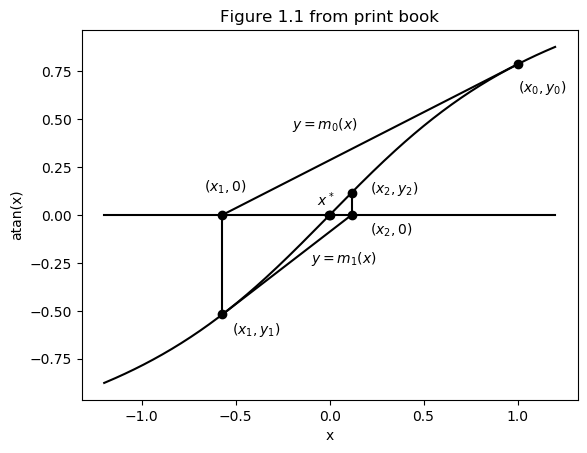

In [11]:
fig1dot1();

The computation of a Newton iteration requires

1. evaluation of $\mf(\vx_n)$ and a test for termination,
2. approximate solution of the equation
$\mf'(\vx_n) \vs = - \mf(\vx_n)$
for the Newton step $\vs$, and
3. construction of $\vx_{n+1} = \vx_n + \lambda \vs$, where the
step length $\lambda$ is selected to guarantee decrease in $\| \mf \|$.


The computation of the Newton step,
consumes most of the work, and the variations
in Newton's method that we discuss in this book differ most significantly
in how the Newton step is approximated. Computing the
step may require evaluation and factorization of the Jacobian matrix
or the solution of the linear equation by an iterative method.
Not all methods for computing
the Newton step require the complete Jacobian matrix, which, as we
will see in [Chapter 2](SIAMFANLCh2.ipynb)
can be very expensive.

In the example from Figure 1.1, the step $s$
in  was
satisfactory, and we can use $\lambda=1$ in step 3. The reader
should be warned that attention to the step length is generally very
important. One should not write one's own nonlinear solver without
step-length control (see [Section 1.6](#Section-1.10:-Global_Convergence_and_the_Armijo_Rule)).



### Section 1.2.1: Local Convergence Theory

The convergence theory for Newton's method 
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>,
that is most often seen in an elementary course in numerical methods
is __local__. This means
that one assumes that the __initial iterate__ $\vx_0$ is near a solution.
The local convergence
theory from
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>,
requires the __standard assumptions__.
    
---
__Assumption:__

1. The equation $\mf(\vx) = 0$ has a solution $\vx^*$.
2. $\mf': \Omega \to R^{N \times N}$ is Lipschitz continuous near $\vx^*$.}
3. $\mf'(\vx^*)$ is nonsingular.
---

Recall that Lipschitz continuity near $\vx^*$
means that there is $\gamma > 0$
(the __Lipschitz constant__) such that
    
$$
\| \mf'(\vx) - \mf'(\vy) \| \le \gamma \| \vx - \vy \|
$$
for all $\vx, \vy$ sufficiently near $\vx^*$.

We state the classic local convergence theorem.

___
__Theorem 1.1__ Let the standard assumptions hold. If $\vx_0$ is sufficiently
near $\vx^*$, then the Newton sequence exists
(i.e., $\mf'(\vx_n)$ is nonsingular
for all $n \ge 0$) and converges to $\vx^*$ and there is $K > 0$ such that
    
$$
\| \ve_{n+1} \| \le K \| \ve_n \|^2
$$
for $n$ sufficiently large.
___


The convergence described by the theorem, in which
the error in the solution will be roughly squared with each iteration,
is called  __q-quadratic__. 
Squaring the error roughly means that the number of significant
figures in the result doubles with each iteration.  Of course,
one cannot examine the error without knowing the solution. However,
we can observe the quadratic reduction in the error computationally,
if $\mf'(\vx*)$ is well conditioned,
because the nonlinear residual
will also be roughly squared with each iteration.
Therefore, we should see the
exponent field of the norm of the nonlinear residual roughly double
with each iteration.
    
In Table 1.1 we report the Newton iteration
for the scalar ($N=1$) nonlinear equation
    
$$
f(x) = \tan(x) - x = 0, \, x_0 = 4.5.
$$
The solution is $x^* \approx 4.493$.

The decrease in the function
is as the theory predicts for the first three iterations, then progress
slows down for iteration 4 and stops completely after that. The
reason for this __stagnation__
is clear: one cannot evaluate the function
to higher precision than (roughly) machine unit roundoff, which in
the IEEE
<cite data-cite="ieee"><a href="siamfa.html#ieee">(IEE85)</cite>,
<cite data-cite="IEEEnew"><a href="siamfa.html#IEEEnew">(IEE19)</cite>,
<cite data-cite="overtonbook"><a href="siamfa.html#overtonbook">(Ove01)</cite>
floating point system is about $10^{-16}$.

We make Table 1.1 with __tab1dot1.jl__.


In [12]:
tab1dot1()

 n       |f(x)| 
 
 0   1.37332e-01  
 1   4.13194e-03  
 2   3.98176e-06  
 3   5.59552e-12  
 4   8.88178e-16  
 5   8.88178e-16  


Stagnation is not affected by the accuracy in the derivative. The
results reported in Table 1.1 used a
forward difference approximation to the derivative with a difference
increment of $10^{-6}$. With this choice of difference increment, the
convergence speed of the nonlinear iteration is as fast as
that for Newton's method, at least for this example, until stagnation
takes over.
The reader should be aware that difference approximations to derivatives,
while usually reliable, are often expensive and can be very inaccurate.
An inaccurate Jacobian can
cause many problems (see 
[Section 1.9](#Section-1.9:-What_Can_Go_Wrong) )

An analytic Jacobian
can require some human effort, but can be worth it in terms of
computer time and robustness when a difference Jacobian performs poorly.

One can quantify this stagnation by adding the errors in the function
evaluation and derivative evaluations to __Theorem 1.1__
The messages of __Theorem 1.2__ are:

---
1. Small errors, for example, machine roundoff, in the function evaluation can lead to stagnation. This type of stagnation is usually benign and, if the Jacobian is well conditioned (see the estimate in [Section 1.5](#Section1.5:-Termination_of_the_Iteration) ),the results will be as accurate as the evaluation of $\mf$

2. Errors in the Jacobian and in the solution of the linear equation for the Newton step will affect the speed of the nonlinear iteration, but not the limit of the sequence.

---



__Theorem 1.2__ 
Let the standard assumptions hold. Let a matrix-valued
function $\Delta(\vx)$ and a vector-valued function $\epsilon(\vx)$
be such that
$$
\| \Delta(\vx) \| < \delta_J \mbox{ and }
\| \epsilon(\vx) \| < \delta_F
$$
for all $\vx$ near $\vx^*$.
Then, if $\vx_0$ is sufficiently near $\vx^*$ and $\delta_J$ and
$\delta_F$ are sufficiently small, the sequence
$$
\vx_{n+1} = \vx_n -
( \mf'(\vx_n) + \Delta(\vx_n))^{-1} (\mf(\vx_n) + \epsilon(\vx_n))
$$
is defined (i.e., $\mf'(\vx_n) + \Delta(\vx_n)$ is nonsingular for all $n$)
and satisfies
$$
\| \ve_{n+1} \| \le {\bar K} ( \| \ve_n \|^2 + \| \Delta(\vx_n) \|
\| \ve_n \|
+ \| \epsilon(\vx_n)\| )
$$
for some ${\bar K} > 0$.

***

We will ignore the errors in the function in the rest of this book,
but one needs to be aware that stagnation of the nonlinear iteration
is all but certain in finite-precision arithmetic. However, the
asymptotic convergence results for exact arithmetic
describe the observations well for most problems.

An important application of __Theorem 1.2__ is the special case where
$\delta_J \approx \sqrt{\delta_F}$, \ie the Jacobian error is roughly the same
as the square root of the function error. In this case the middle term in the error
estimate $\| \Delta(\vx_n) \| \| \ve_n \|$ is smaller than the maximum of the other two.
We state this as a corollary.

---

__Corollary 1.3:__
Let the assumptions of __Theorem 1.2__ hold. Assume that
$\delta_J = O(\sqrt{\delta_F})$. Then $\vx_0$ is sufficiently near $\vx^*$
$$
\| \ve_{n+1} \| = O(  \| \ve_n \|^2  + \epsilon_F ).
$$

---

There are two examples of particular interest. Suppose $\epsilon_F$ is double precision
unit roundoff. If one approximates the Jacobian with a forward difference approximation
with a difference increment of $\sqrt{\epsilon_F}$. In that case the corollary states that
the iteration statistics will be almost indistinguishable from those with an
analytic Jacobian. Similarly, if one stores the Jacobian in single precision, where
the unit roundoff is the square root of $\epsilon_F$, then the estimate in the corollary also holds.
Our solvers exploit this by (1) using a forward difference Jacobian as the default
and (2) allowing a reduced precision Jacobian. The advantage of using a forward difference
Jacobian is that the user (*ie* you) does not have to invest in an analytic Jacobian. The
disadvantage is that an analytic Jacobian is usually faster, in terms of computer time.
The advantages of using a single precision Jacobian are that both the computer time and
the storage burden for the linear solve are cut in half. There are very few disadvantages,
as the corollary indicates. We will explore this in detail later in the book.

While Table 1.1
gives a clear picture of quadratic convergence, it's
easier to appreciate a graph.
Figure 1.2 is a semilog plot of
__residual history__ i.e.,
the norm of the nonlinear residual against the iteration number.
The concavity of the plot is the signature of superlinear convergence.
One uses the __semilogy__ command from the __PyPlot__ package
in Julia for this. See the
file __fig1dot2.jl__, which generated Figure 1.2
for an example.



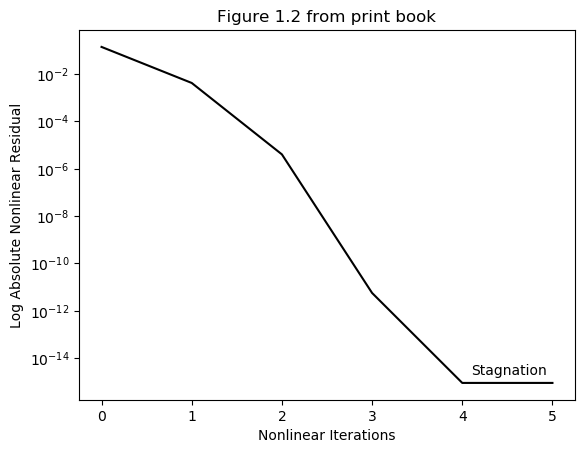

In [13]:
fig1dot2();

## Section 1.3: Approximating the Jacobian

As we will see in the subsequent chapters, it is usually most efficient
to approximate the Newton step in some way.
The price for such an approximation is that the nonlinear iteration
converges more slowly; i.e., more nonlinear iterations
are needed to solve the problem.
However, the overall cost of the solve
is usually significantly less, because the computation of the
Newton step is less expensive.

One way to approximate the Jacobian is to
compute $\mf'(\vx_0)$ and use that as an approximation to
$\mf'(\vx_n)$
throughout the iteration.
This is the __chord method__
or __modified Newton method__.
The convergence
of the chord iteration is not as fast as Newton's method. Assuming
that the initial iteration is near enough to $x^*$, the convergence
is __q-linear__.
This means that there is $\rho \in (0,1)$ such that
$$
\| \ve_{n+1} \| \le \rho \| \ve_{n} \|
$$
for $n$ sufficiently large.
We can apply __Theorem: 1.2__ to the chord method with
$\epsilon=0$ and
$\| \Delta(\vx_n) \| = O(\| \ve_0 \|)$ and conclude that $\rho$ is
proportional to the initial error.
The constant $\rho$ is called the  __q-factor__.
The formal definition of q-linear convergence allows for faster
convergence.
Q-quadratic convergence is also q-linear, as you can see from the
definition.
In many cases of q-linear convergence, one observes that
$$
\| \ve_{n+1} \| \approx \rho \| \ve_{n} \|
\mbox{ or }
\| \mf(\vx_{n+1}) \| \approx \rho \| \mf(\vx_{n}) \|.
$$
In these cases,
q-linear convergence is usually easy to see on a semilog plot of the
residual norms against the iteration number. The curve appears to
be a line with slope $\approx \log(\rho)$.

The __secant method__ 
for scalar equations approximates the
derivative using a finite difference, but, rather than a forward
difference, uses the most recent two iterations to form
the difference quotient. So
$$
x_{n+1} = x_n - \frac{f(x_n)(x_n - x_{n-1})}{f(x_n)- f(x_{n-1})},
$$
where $x_n$ is the current iteration and $x_{n-1}$ is the
iteration before that. The secant method must be initialized
with two points. One way to do that is to let
$x_{-1} = 0.99 x_0$. This is what we do in our Julia code __secant.jl__.

The formula for the secant method does not extend to
systems of equations ($N > 1$) because the denominator in the fraction
would be a difference of vectors. We discuss one of the
many generalizations of the secant method for systems of equations
in 
[Chapter 5](SIAMFANLCh5.ipynb).

The secant method's approximation to $f'(x_n)$ converges to $f'(x^*)$
as the iteration progresses. __Theorem 1.2__, with
$\epsilon=0$ and $\| \Delta(x_n) \| = O(\| e_{n-1} \|)$, implies that
the iteration
converges __q-superlinearly__. This means that either $x_n = x^*$
for some finite $n$ or
$$
\lim_{n \to \infty} \dfrac{\| e_{n+1} \|}{\| e_{n} \|} = 0.
$$
Q-superlinear convergence is hard to distinguish from q-quadratic
convergence by visual inspection of the semilog plot of the residual history.
The residual curve for q-superlinear convergence is concave down
but drops less rapidly than the one for Newton's method.

Q-quadratic convergence is a special case of q-superlinear convergence. More
generally, if $\vx_n \to \vx^*$ and, for some $p > 1$,
$$
\| \ve_{n+1} \| = O(\| \ve_n \|^p),
$$
we say that $\vx_n \to \vx^*$ q-superlinearly with
__q-order__ $p$.

In __Figure 1.3__ we compare Newton's method with the
chord method and the secant method for our model problem that generated __Table 1.1__
and __Figure 1.2__
We see the convergence behavior that the theory
predicts in the linear curve for the chord method and in the concave
curves for Newton's method and the secant method. We also see
the stagnation in the terminal phase.

The figure does not show the division by zero that
halted the secant method computation
at iteration $6$. The secant method
has the dangerous property that the difference between $x_n$
and $x_{n-1}$ could be too small for an accurate difference
approximation. The division by zero that we observed is an extreme
case. We will talk about how we generated this figure with the code __fig1dot3.jl__ later in this chapter.


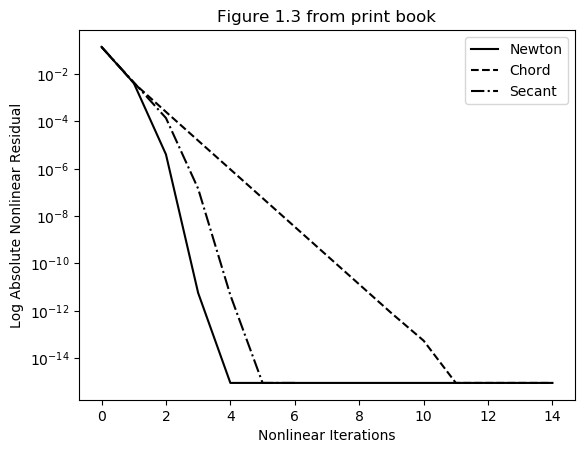

In [14]:
fig1dot3();

## Section 1.4: Inexact Newton Methods

Rather than approximate the Jacobian, one could instead solve
the equation for the Newton step approximately. An
__inexact Newton method__
<cite data-cite="demboes"><a href="siamfa.html#demboes">(Des82)</cite>
uses as a Newton step
a vector $\vs$ that satisfies the
__inexact Newton condition__

$$
\| \mf'(\vx_n) \vs + \mf(\vx_n) \| \le \eta \| \mf(\vx_n) \|.
$$
    
The parameter $\eta$ (the __forcing term__)
can be varied as the Newton iteration progresses.
Choosing a small value of $\eta$ will make the iteration more like
Newton's method, therefore leading to convergence in fewer iterations.
However, a small value of $\eta$ may make computing a step
that satisfies \eqnok{inexact} very expensive. The local convergence
theory
<cite data-cite="demboes"><a href="siamfa.html#demboes">(Des82)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>
for inexact Newton methods reflects the intuitive idea that a small
value of $\eta$ leads to fewer iterations. __Theorem 1.4__
is a typical example of such a convergence result.
    
    
---
__Theorem 1.4__
Let the standard assumptions hold. Then there are $\delta$ and $\bar \eta$
such that, if $\| \ve_0 \| \le \delta$ and
$\{ \eta_n \} \subset [0, \bar \eta]$,
then the inexact Newton iteration
\[
\vx_{n+1} = \vx_n + \vs_n,
\]
where
$$
\| \mf'(\vx_n) \vs_n + \mf(\vx_n) \| \le \eta_n \| \mf(\vx_n) \|,
$$
converges q-linearly to $\vx^*$. Moreover,

- if $\eta_n \to 0$, the convergence is q-superlinear, and
- if $\eta_n \le K_\eta \| \mf(\vx_n) \|^p$ for some
$K_\eta > 0$, the convergence is q-superlinear with q-order $1+p$.
    
___

Errors in the function evaluation will, in general, lead to
stagnation of the iteration.

One can use __Theorem 1.4__ to analyze the chord method or
the secant method. In the case of the chord method, the steps
satisfy the inexact Newton condition with
$$
\eta_n = O(\| \ve_0 \|),
$$
which implies q-linear convergence if $\| \ve_0 \|$ is sufficiently small.
For the secant method, $\eta_n = O(\| \ve_{n-1} \|)$, implying
q-superlinear convergence. 
    
Iterative methods (such as GMRES
<cite data-cite="gmres"><a href="siamfa.html#gmres">(SS86)</cite>) for solving
the equation for the Newton step would typically use
the inexact Newton condition as a termination criterion. In this case, the
overall nonlinear solver is called a
__Newton iterative method__.
Newton iterative methods are named by the
particular iterative method used for the linear equation. For
example, the Newton-Krylov solvers in the __nsol.jl__ code,
which we describe in [Chapter 3](SIAMFANLCh3.ipynb), include Newton-GMRES.

An unfortunate choice of the forcing term $\eta$ can lead to
very poor results. The reader is invited to try the two
choices $\eta = 10^{-6}$ and $\eta = .9$ in __nsol.jl__
to see this. Better choices of $\eta$ include $\eta = 0.1$,
the author's personal favorite, and a more complex approach
(see [Chapter 3](SIAMFANLCh3.ipynb))
from 
<cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
and
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>
that is the
default in __nsol.jl__. Either of these  usually leads to
rapid convergence near the solution, but at a much lower cost
for the linear solver than a very small forcing term such as
$\eta = 10^{-4}$.



## Section 1.5: Termination of the Iteration

While one cannot know the error without
knowing the solution, in most cases the norm of $\mf(\vx)$ can be used
as a reliable indicator of the rate of decay in $\| \ve \|$ as the
iteration progresses \cite{ctk:roots}. Based on this heuristic, we
terminate the iteration in our codes when

$$
\| \mf(\vx) \| \le \tau_r \| \mf(\vx_0) \| + \tau_a.
$$

The relative $\tau_r$
and absolute $\tau_a$ error tolerances are
both important. Using only the relative reduction in the
nonlinear residual as a basis for termination (i.e., setting $\tau_a = 0$)
is a poor idea because an initial iterate that is near the solution
may make the criterion impossible to satisfy with $\tau_a = 0$.

One way to quantify the utility of termination when
$\| \mf(\vx) \|$
is small is to compare a relative reduction in the norm of the
error with a relative reduction in the norm of the nonlinear residual.
If the standard assumptions hold and
\vx_0$ and $\vx$ are sufficiently near the root, then
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>

$$
\frac{\| \ve \|}{4 \| \ve_0 \| \kappa(\mf'(\vx^*))} \le
\frac{\| \mf(\vx) \|}{\| \mf(\vx_0) \|}
\le \frac{4 \kappa(\mf'(x^*)) \| \ve \|}{\| \ve_0 \|},
$$
    
where
    
$$
\kappa(\mf'(\vx^*)) = \| \mf'(\vx^*)\| \| \mf'(\vx^*)^{-1} \|
$$
    
is the
__condition number__ of $\mf'(\vx^*)$ relative to the norm
$\| \cdot \|$. From the estimate above which compares relative error and
relative resiual, we conclude that, if the
Jacobian is well conditioned (i.e., $\kappa(\mf'(\vx^*))$ is not
very large), then our termination criterion useful.
This is analogous to the linear case, where
a small residual implies a small error if the matrix is well conditioned.
    
Another approach, which is supported by theory only for superlinearly
convergent methods,
is to exploit the fast convergence to estimate the error in
terms of the step. If the iteration is converging superlinearly, then
    
$$
\ve_{n+1} = \ve_n + \vs_n = o(\| \ve_n \|)
$$
    
and hence
    
$$
\vs_n = -\ve_n + o(\| \ve_n \|).
$$
    
Therefore, when the iteration is converging superlinearly, one may
use $\| \vs_n \|$ as an estimate of $\| \ve_n \|$. One can estimate the
current rate of convergence from above by
    
$$
\rho_n = \| \vs_n \|/\| \vs_{n-1} \| \approx \| \ve_n \|/\| \ve_{n-1} \|
\ge \| \ve_{n+1} \|/\| \ve_n \|.
$$
    
Hence, for $n$ sufficiently large,
    
$$
\| \ve_{n+1} \| \le \rho_n \| \ve_n \| \approx \| \vs_n \|^2/\| \vs_{n-1}\|.
$$
    
So, for a superlinearly convergent method, terminating the iteration
with $\vx_{n+1}$ as soon as

$$
\| \vs_n \|^2/\|\vs_{n-1}\| < \tau
$$
will imply that $\| \ve_{n+1} \| < \tau$. This is __termination on small steps__.
    
Termination on small steps
is only supported by theory for superlinearly convergent
methods, but is used for linearly convergent methods in some
initial value problem solvers 
<cite data-cite="slc"><a href="siamfa.html#slc">(BCP96)</cite>,
<cite data-cite="lsode"><a href="siamfa.html#lsode">(RH93)</cite>.
The trick is
to estimate the q-factor $\rho$, say, by
    
$$
\rho \approx \| \vs_n \|/\| \vs_{n-1} \|
\mbox{ or }
\rho \approx (\| \vs_n \|/\| \vs_0 \|)^{1/n}.
$$
    
Assuming that the estimate of $\rho$ is reasonable, then
    
$$
\| \ve_n \| - \| \vs_n \| \le \| \ve_{n+1} \| \approx \rho \| \ve_n \|
$$
    
implies that
    
$$
\| \ve_{n+1} \|/\rho \approx \| \ve_n \| \le \| \vs_n \|/(1 - \rho).
$$
    
Hence, if we terminate the iteration when

$$
\| \vs_n \| \le \tau (1 - \rho)/\rho
$$
    
and the estimate of $\rho$ is an __overestimate__, then
the termination on small steps criterion will imply that
    
$$
\| \ve_{n+1} \| \le \rho \| \vs_n \|/(1-\rho)  \le \tau.
$$
    
In practice, a safety factor is used on the left side of these criteria
to guard against an underestimate.

If, however, the estimate of $\rho$ is much smaller than the actual
q-factor, the iteration can terminate too soon. This can happen
in practice if the Jacobian is ill conditioned and the initial iterate
is far from the solution
<cite data-cite="ctk:mike2"><a href="siamfa.html#ctk:mike2">(KMT98)</cite>.


## Section 1.6: Global Convergence and the Armijo Rule

The requirement in the local convergence theory
that the initial iterate be near the solution is
more than mathematical pedantry. To see this, we apply
Newton's method to find the root $x^* = 0$ of the
function $f(x) = \arctan(x)$ with initial iterate $x_0 = 10$. This
initial iterate is too far from the root for the local convergence
theory to hold. In fact, the step

$$
s = \frac{f(x_0)}{f'(x_0)} \approx \frac{1.5}{-0.01} \approx -150,
$$

while in the correct direction, is far too large in magnitude.

The initial iterate and the four subsequent iterates are

$$
10, -138, 2.9 \times 10^4, -1.5 \times 10^9, 9.9 \times 10^{17}.
$$

As you can see, the Newton step points in the correct direction,
i.e., toward $x^* = 0$, but overshoots by larger and larger amounts.
The simple artifice of reducing the step by half
until $\|\mf(\vx)\|$ has been reduced will usually solve this problem.

In order to clearly describe this, we will now
make a distinction between the
__Newton direction__
$\vd = -\mf'(\vx)^{-1} \mf(\vx)$ and the
__Newton step__ when we discuss global
convergence. For the methods in this book, the Newton step
will be a positive scalar multiple of the Newton direction.
When we talk about local convergence and are taking
full steps ($\lambda = 1$ and $\vs = \vd$), we will not make this
distinction and only refer to the step, as we have been doing
up to now.

A rigorous convergence analysis requires a bit more detail. We
begin by computing the __Newton direction__
$$
\vd = - \mf'(\vx_n)^{-1} \mf(\vx_n).
$$

To keep the step from going too far, we find the smallest integer $m \ge 0$
such that the __sufficient decrease condition__

$$
\|\mf(\vx_n + 2^{-m} \vd) \| < (1 - \alpha 2^{-m} ) \| \mf(\vx_n) \|
$$

holds. We let the step be $\vs = 2^{-m} \vd$ and
$\vx_{n+1} = \vx_n + 2^{-m} \vd$.

The parameter $\alpha \in (0,1)$ is a small
number intended to make the sufficient decrease condition as easy as possible
to satisfy.
$\alpha = 10^{-4}$ is typical and used in our codes.

In the figure (Figure 1.4 in the print book) 
created by __fig1dot4.jl__,
we show how this approach, called the
__Armijo rule__ 
<cite data-cite="armijo"><a href="siamfa.html#armijo">(Arm66)</cite>,
succeeds. The
circled points are iterations for which $m > 1$ and the value of
$m$ is above the circle.



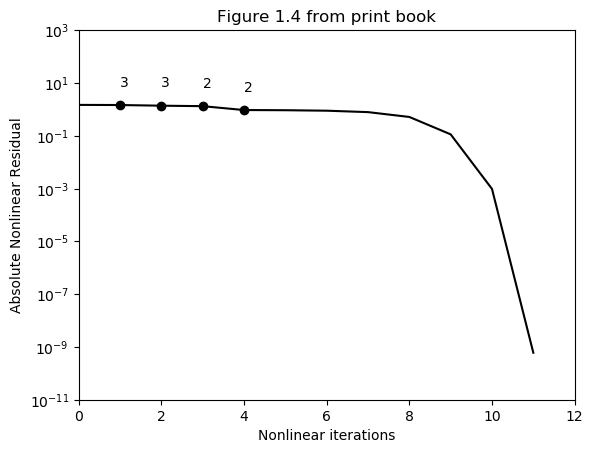

In [15]:
fig1dot4();

Methods like the Armijo rule are called
__line search__ methods because one searches
for a decrease in $\| \mf \|$ along the line segment
$[\vx_n, \vx_n + \vd]$.

The line search in our codes manages the reduction in the step size
with more sophistication than simply halving an unsuccessful step.
The motivation
for this is that some problems respond well to one or two reductions
in the step length by modest amounts (such as 1/2)
and others require many such reductions, but might do much
better if a more
aggressive step-length reduction (by factors of 1/10, say) is used.
To address this possibility, after two reductions by halving do
not lead to sufficient decrease, we build a quadratic polynomial model of
$$
\phi(\lambda) = \|F(\vx_n + \lambda \vd) \|^2
$$
based on interpolation of $\phi$ at $\lambda=0$ (the current iterate)
and the two most
recent values of $\lambda$. The next $\lambda$ is the
minimizer of the quadratic model, subject to the
__safeguard__ that the reduction in $\lambda$ be at least
a factor of two and at most a factor of ten. So
the algorithm generates a sequence of candidate step-length factors
$\{ \lambda_m \}$ with $\lambda_0 = 0, \lambda_1=1$ (a full step) and
$$
1/10 \le \lambda_{m+1}/\lambda_m \le 1/2.
$$
The norm in this equation is, at least for theory, understood to be the
$\ell^2$ norm and is squared to make $\phi$ a smooth
function that can be accurately modeled by a quadratic over
small ranges of $\lambda$.

In the advanced codes from the subsequent chapters,
we use the three-point parabolic model from 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>. In
this approach, $\lambda_1 = 1/2$. To compute $\lambda_m$ for
$m > 1$, a parabola is fitted to the data $\phi(0)$,
$\phi(\lambda_m)$, and
$\phi(\lambda_{m-1})$. $\lambda_m$ is the minimum of this parabola on the
interval $[\lambda_{m-1}/10,\lambda_{m-1}/2]$. We refer the reader
to 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite> for the details and
to 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>,
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
for a discussion of other ways
to implement a line search.

In Figure 1.5 we apply the 
parabolic line search to the problem from Figure 1.4.
As you can see iteration with the polynomial line search avoids the 
repeated stepsize reductions early in the iteration and finds the 
solution in significantly fewer function evaluations.

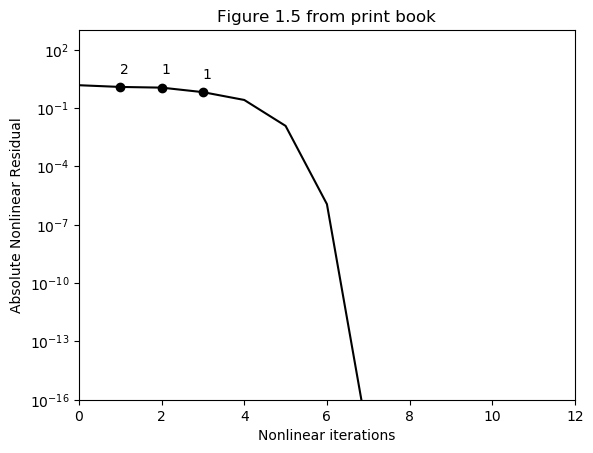

In [16]:
fig1dot5();

### Section 1.6.1:  A Basic Algorithm

Algorithm __nsolg__ is a general formulation of an inexact
Newton--Armijo iteration. The methods in 
[Chapter 2](SIAMFANLCh2.ipynb) and
[Chapter 3](SIAMFANLCh3.ipynb)
are special cases of __nsolg__. There is
a lot of freedom in Algorithm __nsolg__. The essential input
arguments are the initial iterate $\vx$, the function $\mf$, and
the relative and absolute termination tolerances $\tau_a$
and $\tau_r$. If __nsolg__ terminates successfully,
$\vx$ will be the approximate solution on output.

Within the algorithm, the computation of the
Newton direction $\vd$ can be done with direct or iterative
linear solvers, using either the Jacobian $\mf'(\vx)$ or an
approximation of it. If you use a direct solver, then
the forcing term $\eta$ is determined implicitly; you do
not need to provide one. For example, if you solve the
equation for the Newton step with a direct method, then
$\eta = 0$ in exact arithmetic. If you use an approximate
Jacobian and solve with a direct method, then $\eta$ is
proportional to the error in the Jacobian. Knowing about
$\eta$ helps you understand and apply the theory, but is not
necessary in practice if you use direct solvers.

If you use an iterative linear solver, then usually
the inexact Newton condition is the termination criterion for that
linear solver. You'll need to make a decision about the forcing term
in that case (or accept the defaults from a code like
__nsol.jl__, which we describe in [Chapter 3](SIAMFANLCh3.ipynb).
The theoretical
requirements on the forcing term $\eta$ are that it be safely
bounded away from one.

Having computed the Newton direction, we compute a step length
$\lambda$ and a step $\vs = \lambda \vd$ so that the sufficient
decrease condition holds. It's standard in line search
implementations to use a polynomial model like the one we described
above.

The algorithm does not cover all aspects of a useful implementation.
The number of nonlinear iterations, linear iterations, and
changes in the step length all should be limited. Failure of any
of these loops to terminate reasonably rapidly
indicates that something is wrong. We list some of the potential
causes of failure in the subsequent sections.

In
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>
the argument list began with $\vx, \mf$. Here, following
Julia convention 
<cite data-cite="Julia20"><a href="siamfa.html#Julia20">(Pro20)</cite>,
we put the function argument first in Algorithm __nsolg__.


![Alg1.1](Images/Alg1dot1.png)


The theory for Algorithm __nsolg__ is very satisfying.
If $\mf$ is sufficiently smooth, $\eta$
is safely bounded away from one,
the Jacobians remain well conditioned throughout the iteration, and
the sequence $\{ \vx_n \}$
remains bounded, then the iteration converges to a solution
and, when near the solution, the convergence is as fast as the quality of
the linear solver permits. __Theorem 1.4__ states this precisely,
but not as generally as the results in 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>.
The important thing that you should remember is that, for smooth $F$,
there are only three possibilities for the iteration of
Algorithm __nsolg__:

- $\{ \vx_n \}$ will converge to a solution $\vx^*$, at which the standard
assumptions hold,
- $\{ \vx_n \}$ will be unbounded, or
- $\mf'(\vx_n)$ will become singular.


While the line search paradigm is the simplest way to find a solution
if the initial iterate is far from a root, other methods are available.
__Trust region__ globalization 
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="powelltreq"><a href="siamfa.html#powelltreq">(Pow70)</cite>
is widely used for
optimiztion problems, but less so for nonlinear equations.    
    
__Pseudotransient continuation__ 
<cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite>,
<cite data-cite="ctk:ptc2"><a href="siamfa.html#ctk:ptc2">(CKK03)</cite>,
<cite data-cite="highamptc"><a href="siamfa.html#highamptc">(Hig99)</cite>,
<cite data-cite="deufptc"><a href="siamfa.html#deufptc">(Deu02)</cite>
is designed to steer the iteration to dynamically stable solutions.
__Homotopy__ methods 
<cite data-cite="bertini"><a href="siamfa.html#bertini">(BHSW13)</cite>,
<cite data-cite="hompack"><a href="siamfa.html#hompack">(WBM87)</cite>
an be deployed to find all
solutions of nonlinear equations.
We will cover pseudotransient continuation in some detail the next section.

---
    
__Theorem 1.5:__
Let $\vx_0 \in R^N$ and $\alpha \in (0,1)$ be given.
Assume that $\{ \vx_n \}$ is given by Algorithm __nsolg__,
$\mf$ is Lipschitz continuously differentiable,
    
$$
\{ \eta_n \} \subset (0, \bar \eta] \subset (0,1-\alpha),
$$
    
and $\{ \vx_n \}$ and $\{\| \mf'(\vx_n)^{-1} \|\}$ are bounded.
Then $\{ \vx_n \}$ converges to a root $\vx^*$ of
$\mf$ at which the standard assumptions hold, full steps
($\lambda = 1$) are taken for
$n$ sufficiently large, and the convergence behavior in the final phase
of the iteration is that given by the local theory for inexact
Newton methods (__Theorem 1.4__).
    
---


### Section 1.6.2: Warning!

The theory for global convergence of the inexact Newton--Armijo iteration
is only valid if $\mf'(\vx_n)$, or a very good approximation
(forward difference, for example), is used to compute the step.
A poor approximation to the Jacobian will cause the Newton step
to be inaccurate. While this can result in slow convergence when
the iterations are near the root, the outcome can be much worse
when far from a solution. The reason for this is that the success
of the line search is very sensitive to the direction.
In particular, if
$\vx_0$ is far from $\vx^*$ there is __no reason__ to expect the
secant or chord method, even with a line search, to converge. Sometimes methods like
the secant and chord methods work fine with a line search when
the initial iterate is far from a solution, but users of
nonlinear solvers should be aware that the line search can fail.
A good code will watch for this failure and respond by
using a more accurate Jacobian or Jacobian-vector product or reporting an error.

Difference approximations to the Jacobian are usually sufficiently
accurate. However, there are particularly hard problems
<cite data-cite="kerksaad"><a href="siamfa.html#kerksaad">(KS92)</cite>
for which differentiation in the coordinate
directions is very inaccurate, whereas differentiation in
the directions of the iterations, residuals, and steps,
which are natural directions
for the problem, is very accurate.
The inexact Newton methods, such as the
Newton-Krylov methods in 
[Chapter 3](SIAMFANLCh3.ipynb), use a forward
difference approximation for Jacobian-vector products
(with vectors that are natural for the problem) and, therefore,
will usually (but not always) work well when far from a solution.


## Section 1.7: Pseudo-Transient Continuation

Nonlinear equations can have multiple solutions and even if the Newton-Armijo iteration converges to a solution, that may not be the solution you want. __Pseudo-Transient Continuation__ ($\ptc$) is one way to differentiate solutions you want from the ones you don't.

Much of this section is taken from 
<cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite>
and 
cite{ctk:acta}.
<cite data-cite="ctk:acta"><a href="siamfa.html#ctk:acta">(Kel18)</cite>.
We refer the reader to 
<cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite>,
<cite data-cite="ctk:ptc2"><a href="siamfa.html#ctk:ptc2">(CKK03)</cite>
and 
<cite data-cite="ctk:katie2"><a href="siamfa.html#ctk:katie2">(FK05)</cite>
for the details of the analysis.

The objective is
to find stable steady-state solutions of time-dependent problems
$$
\frac{d \vx}{dt} = -\mv \mf(\vx), \  \vx(0) = \vx_0.
$$
The minus sign on the right side of the equation is
a convention.
The matrix $\mv$ is a nonsingular
scaling matrix, usually diagonal.
$\mv$ plays an important role in applications 
<cite data-cite="keyes-smooke"><a href="siamfa.html#keyes-smooke">(KS87)</cite>
and
will play a role in the theory. We will
set $\mv = \mi$ in the examples in this book.
    
We assume that a solution $\vx(t)$ exists for $0 \le t < \infty$.
Here $\mf$ is a Lipschitz continuously differentiable
function in a neighborhood of the trajectory
$\{ \vx(t) \, | \, 0 \le t \le \infty \}$.
We assume that a {\bf steady-state} solution $\vx^*$ of \eqnok{timedep}
exists. This means that
$$
\lim_{t \to \infty} \vx(t) = \vx^*.
$$
The convergence of $\vx(t)$ implies that
$$
\frac{d \vx^*}{dt} = 0 = - \mf(\vx^*).
$$
A steady state solution is __stable__ if
if the solution of
the initial value problem with initial data
sufficiently near $\vx^*$ converges to $\vx^*$ as $t \to \infty$. We
will only consider linear stability, which for us will mean
that there is $\beta > 0$ such that
$$
\| (\mi - \delta \mv^{-1} \mf'(\vx^*) \| \le (1 + \beta \delta)^{-1}
$$
for all $\delta > 0$. This will imply stability, but the converse is not
true.




### Section 1.7.1: A Simple Example

A simple ordinary differential equation makes the point.
In this example $f(x) = (x^3 - \lambda x)$ where $\lambda$ is a
parameter in the equation.
The equation
$$
\frac{d x}{dt} = - (x^3 - \lambda x)
$$
has a unique steady-state solution $x \equiv 0$ if $\lambda \le 0$.
That solution is stable because $f'(0) = - \lambda \ge 0$. When
$\lambda > 0$, however, there are three steady state solutions
$$
x \equiv \pm \sqrt{\lambda} \mbox{ and } x \equiv 0.
$$
The two nonzero solutions are stable and $x \equiv 0$ is not.
If one solves $f(x) = 0$ with Newton's method the iteration is
$$
x_+ = \frac{-2 x_c^3}{\lambda - 3 x_c^2}.
$$
Hence Newton's method will converge to the unstable solution if
the initial iterate $x_0$ is sufficiently small.

The solution of initial value problem, on the other hand, will
converge to one of the steady state solutions.
Numerical integration with Euler's method
$$
x_{k+1} = x_k - h f(x_k) = x_k - h (x_k^3 - \lambda x_k)
= (1 + h \lambda) x_k - h x_k^3
$$
will find the solution if $h$ is sufficiently small. To see that
note that $x_{k+1} > x_k$ if $x_k > 0$ is small. Hence
the numerical integration converges to the stable steady-state solution
for sufficiently small $h$. So the problem is that Newton's method
can converge to the unstable solution, which is not of interest, but
a highly accurate temporal integration, while finding a steady-state
solution, is very costly.




### Section 1.7.2: The $\ptc$ Algorithm

The $\ptc$ sequence $\{ \vx_n \}$ is
$$
\vx_{n+1} = \vx_n - ( \delta_n^{-1} \mv + \mf'(\vx_n) )^{-1} \mf(\vx_n).
$$
If $\delta_n$ were small and fixed, this would be a
Rosenbrock method
<cite data-cite="gear"><a href="siamfa.html#gear">(Gea71)</cite>
for temporal integration. The objective of $\ptc$ is fast convergece to steady-state. That
is very different from accurate temporal integration, hence the name __pseudo-transient__
continuation. Another way to view the iteration is as a
single Newton step for the implicit Euler time step
$$
\vx_{n+1}  = \vx_n + \delta_n \mv \mf(\vx_{n+1}).
$$
This viewpoint plays an important role in the theory from
<cite data-cite="ctk:todd1"><a href="siamfa.html#ctk:todd1">(CMKM03)</cite>,
<cite data-cite="ctk:ptc2"><a href="siamfa.html#ctk:ptc2">(CKK03)</cite>,
<cite data-cite="ctk:katie2"><a href="siamfa.html#ctk:katie2">(FK05)</cite>, and
<cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite>.
We think of $\ptc$ as a variable timestep algorithm that
attempts to increase the time step as $\| \mf(\vx(t)) \|$ becomes
small. So we manage $\delta$ very differently from a variable-step
initial value problem solver, where time step control is for stability
and temporal accuracy.

We will consider the simplest case for smooth $\mf$ and ordinary
differential equation dynamics. $\ptc$ has also succeeded with
differential algebraic equations and nonsmooth dynamics
<cite data-cite="ctk:todd1"><a href="siamfa.html#ctk:todd1">(CMKM03)</cite>,
<cite data-cite="ctk:ptc2"><a href="siamfa.html#ctk:ptc2">(CKK03)</cite>,
<cite data-cite="ctk:katie2"><a href="siamfa.html#ctk:katie2">(FK05)</cite>.

The formal statement of the algorithm is a bit simpler than that for
Newton-Armijo.
The implementation is also simpler. For Newton-Armijo,
as we shall see, one has options in the frequency of the Jacobian
evaluation and factorization, the nature of any approximation of the
Jacobian, and the rules for stepsize control. $\ptc$, on the other hand,
needs to use the Jacobian at the current iteration to preserve the
dynamics early in the iteration and controls $\delta$ with a formula.

We update $\delta$ with the
__switched evolution relaxation__ (SER) method
<cite data-cite="mulder_vanleer"><a href="siamfa.html#mulder_vanleer">(ML85)</cite>
approach which is widely used in aerodynamics
<cite data-cite="Keyes"><a href="siamfa.html#Keyes">(Key95)</cite>,
<cite data-cite="mcraeork"><a href="siamfa.html#mcraeork">(OM92b)</cite>,
<cite data-cite="mcraeork2"><a href="siamfa.html#mcraeork2">(OM92a)</cite>,
<cite data-cite="venkat"><a href="siamfa.html#venkat">(Ven89)</cite>,
$$
\delta_n = \delta_{n-1} \|\mf(\vx_{n-1})\|/\|\mf(\vx_n)\| =
\delta_0 \|\mf(\vx_0)\|/\|\mf(\vx_n)\|
$$
or
$$
\delta_n =
\phi\left(\delta_{n-1}\frac{\|\mf(\vx_{n-1})\|}{\|\mf(\vx_n)\|}\right).
$$
In the SER equation
$$
\phi(\xi) = \left\{\begin{array}{@{}lc@{}}
\xi, & \xi \leq \xi_t, \\
\delta_{\max} , & \xi > \xi_t, \end{array}\right.
$$
where either $\xi_t = \delta_{\max}$ or $\xi_t < \infty$
and $\delta_{\max} = \infty$.
The choice $\delta_{\max} = \infty$ is the original form of SER.

Algorithm __ptc__ has been used in aerodynamics 
<cite data-cite="venkat"><a href="siamfa.html#venkat">(Ven89)</cite>,
hydrology 
<cite data-cite="ctk:ptcre"><a href="siamfa.html#ctk:ptcre">(FKC<sup>+</sup>03)</cite>,
mechanics
<cite data-cite="ctk:rich"><a href="siamfa.html#ctk:rich">(GLK09)</cite>, magnetohydrodynamics <cite data-cite="knoll1"><a href="siamfa.html#knoll1">(KR97)</cite>, radiation transport <cite data-cite="Shestakov00"><a href="siamfa.html#Shestakov00">(SM00)</cite>, reacting flow  <cite data-cite="smooke2"><a href="siamfa.html#smooke2">(SMK89)</cite>, structural analysis  <cite data-cite="kant90"><a href="siamfa.html#kant90">(KP90)</cite>, optimization <cite data-cite="ctk:ptcopt"><a href="siamfa.html#ctk:ptcopt">(KLQ<sup>+</sup>08)</cite>, and circuit simulation 
<cite data-cite="grasser99"><a href="siamfa.html#grasser99">(Gra99)</cite>.    
In all of these applications,
time-accurate integration to steady-state is far too costly to be useful.

![Alg1.2](Images/Alg1dot2.png)
    
Unlike the Newton-Armijo algorithm, $\ptc$ allows $\| \mf (\vx) \|$ to
increase as the iteration progresses. \ptc responds to such an increase
by decreasing $\delta$ and thereby better following transient behavior.
This is exactly the right thing to do. Insisting on a decrease in
$\| \mf(\vx) \|$ as Newton-Armijo does, can lead to convergence to
to an unstable steady state
or even stagnation at local minimum
of $\| \mf \|$ 
<cite data-cite="keyes-smooke"><a href="siamfa.html#keyes-smooke">(KS87)</cite>, at which $\mf'$ is singular.
These problems are
common when when the time-dependent solution has complex features
such as shocks and rarefactions on the trajectory between $\vx_0$ and
$\vx^*$ (see 
<cite data-cite="mcraeork"><a href="siamfa.html#mcraeork">(OM92b)</cite> and
<cite data-cite="mcraeork2"><a href="siamfa.html#mcraeork2">(OM92a)</cite>
for example).
$\ptc$ succeeds in many of these cases by taking advantage of the
dynamic structure of the problem and following the dynamics early in
the iteration.


### Section 1.7.3: Convergence Theory

We begin by summarizing the assumptions from 
<cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite> which
we need for convergence.

---
__Assumption:__

- The initial value problem $d \vx/dt = - \mf(\vx), \ \vx(0)=\vx_0$ has a steady-state
solution $\vx^* = lim_{t \to \infty} \vx(t)$.

- There is a neighborhood of the trajectory
$\{ \vx(t) \, | \, 0 \le t < \infty \}$ in which
$\mf'$ is uniformly Lipschitz continuous.
\item There is $\beta > 0$ such that
$$
\| (\mi - \delta \mv^{-1} \mf'(\vx^*) \| \le (1 + \beta \delta)^{-1}
$$

---

The convergence result is very different from __Theorem 1.5__.
In __Theorem 1.6__ we specify the target solution $\vx^*$ in advance
and link $\vx_0$ to $\vx^*$ with the dynamics. The nonsingularity
assumption on $\mf(\vx^*)$ is stronger than in the standard assumptions
for local convergence as well.

---
__Theorem 1.6:__
Let the $\ptc$ Assumptions hold and assume that
$\delta$ is updated by SER.
Let $\{ \vx_n \}$ be the iteration from Algorithm __ptc__.
Assume that $\eta_n \le {\bar \eta}$ for all $n$. Then if $\delta_0$
and ${\bar \eta}$ are sufficiently small, then
$\vx_n \to \vx^*$ and $\delta_n \to \delta_{max}$. Moreover,
for $n$ sufficiently large,

$$
\| \ve_{n+1} \| = O{ ( \eta_n + \delta_n^{-1} ) \| \ve_n \|
+ \| \ve_n \|^2}.
$$



### Section 1.7.4: Computational Example

We illustrate the effects of $\ptc$ with the example from
Section 1.7.1. We compare a Newton iteration to
a $\ptc$ iteration for $\lambda = .5$ with $x_0 = .1$. \ptc will
move away from the unstable solution $x^*_{us} = 0$ and converge
to the stable solution $x^* = \sqrt{1/2}$.

The reader must be aware that
$\ptc$ __is NOT a general-purpose nonlinear solver__. We will return
to this theme in 
[Chapter 2](SIAMFANLCh2.ipynb) and
[Chapter 3](SIAMFANLCh3.ipynb).
$\ptc$ was
invented to find steady-state solutions of time-dependent problems.
The price for that ability is that $\ptc$ generally needs many more iterations
to do its work and must (in both theory and practice) use an accurate
Jacobian, not, for example, the Jacobian from a prior iteration.

Figure 1.6 compares the convergence of $\ptc$
and Newton's method on the example problem
$f(x) = (x^3 - \lambda x)$ from Section 1.7.1. Here we take
$\lambda = 1/2$ and $x_0 = .1$. The $\ptc$ iteration will converge to
the postive steady-state solution $x^* = \sqrt{1/2}$ while Newton's method
converges to the unstable solution $x^* = 0$. We plot both the residual
norm and the error. There are two things to mention in this plot.


- $\ptc$ takes many more iterations to converge. This is because it
accurately tracks the dynamics early in the iteration and takes several
steps as it does that.

- The two plots look
very similar because the derivative of $f$ at either of the two solutions
is neither near zero nor too large.



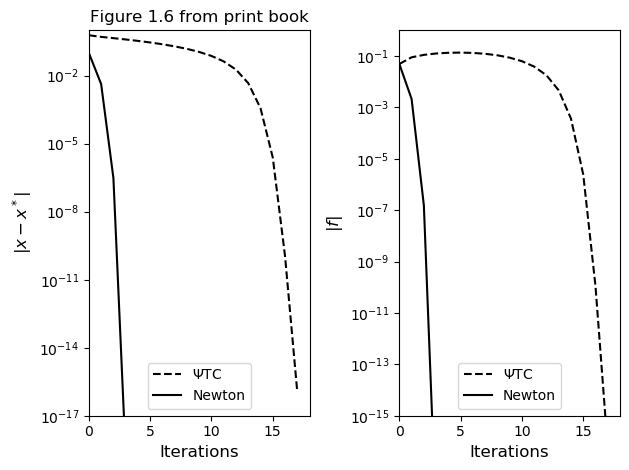

In [17]:
fig1dot6();


Figure 1.7 shows how the choice of $dt_0$ affects
the convergence. In this example reducing $dt_0$ forces a more
accurate and costly resolution of the transients in the dynamics.
Since our choice of $dt_0 = .1$ found the correct steady-state solution,
smaller values of $dt_0$ only result in wasted effort. Of course, a value
of $dt_0$ that is too large will lead to convergence to the unstable
solution, as we will see in [Section 1.10](SIAMFANLCh1a.ipynb).


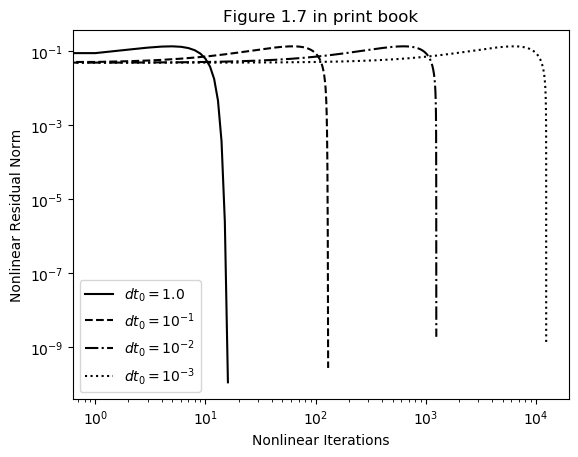

In [18]:
fig1dot7();

## Section 1.8: Things to Consider

Here is a short list of things to think about when you select
and use a nonlinear solver.

### Human Time and Public Domain Codes

When you select a nonlinear solver for your problem, you need
to consider not only the computational cost (in time and
storage) but also __YOUR TIME__. A fast code for your problem
that takes ten years to write has little value.

Unless your problem is very simple, or you're an expert in
this field, your best bet is to use a
open source or
public domain code.
The Julia codes that accompany this book
are a good start and
can be used for small- to medium-scale production work.
The Matlab codes from 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite> and
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>
serve the same purpose.
However, if you need support for other languages
(meaning C, C++, or FORTRAN) or
high-performance computing environments, there are several
sources for public domain implementations of the algorithms
in this book.

The Newton--Krylov solvers we discuss in [Chapter 3](SIAMFANLCh3.ipynb)
are at present (2020) the solvers
of choice for most large problems on advanced computers. Therefore,
these algorithms are getting most of the attention from
the people who build libraries. The NOX solver in the
Trilinos framework 
<cite data-cite="trilinos"><a href="siamfa.html#trilinos">(HBH<sup>+</sup>05)</cite>,    
the
SNES  solver in the
PETSc library 
<cite data-cite="petsc-web-page"><a href="siamfa.html#petsc-web-page">(BAA<sup>+</sup>19)</cite>,    
and the NITSOL
<cite data-cite="nitsol"><a href="siamfa.html#nitslo">(PW98)</cite>,
NKSOL
<cite data-cite="brown/saad90"><a href="siamfa.html#brown/saad90">(BS90)</cite>,
and {KINSOL}
<cite data-cite="kinsol"><a href="siamfa.html#kinslo">(TH98)</cite> 
codes
are good implementations. KINSOL has been ported to Julia as part
of the [SUNDIALS.jl](https://github.com/SciML/Sundials.jl) package
<cite data-cite="sundials"><a href="siamfa.html#sundials">(HBG<sup>+</sup>05)</cite>,
<cite data-cite="dejl"><a href="siamfa.html#dejl">(RN17)</cite>.
    
The methods from [Chapter 2](SIAMFANLCh2.ipynb), which are based on direct
factorizations, have received less attention recently and many of the codes are quite old.   
Some
careful implementations can be found in the MINPACK and UNCMIN
libraries. The MINPACK
<cite data-cite="minpack1"><a href="siamfa.html#minpack1">(MGH80)</cite>
library is a suite of FORTRAN
codes that includes an implementation of Newton's method
for dense Jacobians. The globalization is via a trust region
approach 
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="powelltreq"><a href="siamfa.html#powelltreq">(Pow70)</cite>,      
rather than the line search method we use here. The UNCMIN 
<cite data-cite="uncmin"><a href="siamfa.html#uncmin">(SKW85)</cite> library is based
on the algorithms from
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>and includes a Newton--Armijo
nonlinear equations solver.
MINPACK and several other codes for solving nonlinear equations
are available from the [NETLIB](http://www.netlib.org)
repository. Some of the
NETLIB codes are very old and may not be maintained.

Jacobians and even directional derivatives are difficult or
impossible to obtain in some applications. The SCF (self-consistent
field) iteration in electronic
structure computations (see <cite data-cite="dedrichszeller"><a href="siamfa.html#dedrichszeller">(DZ83)</cite>,
<cite data-cite="linbook"><a href="siamfa.html#linbook">(LL19)</cite>,
<cite data-cite="Saad2010"><a href="siamfa.html#Saad2010">(SCS10)</cite>,    
and the references in these papers) in computational physics and
chemistry is one such example. Anderson acceleration 
<cite data-cite="Anderson1965"><a href="siamfa.html#Anderson1965">(And65)</cite>,
which we cover in [Chapter 4](SIAMFANLCh4.ipynb)
is a one approach for
such problems. There are good implementations of Anderson acceleration in SUNDIALS and Trilinos.

There is an implementation of Broyden's method, covered [Chapter 5](SIAMFANLCh5.ipynb) in in
UNCMIN. This implementation is based
on dense matrix methods. The Julia implementation
that accompanies this book requires much less storage and
computation.

### The Initial Iterate
    
Picking an initial iterate at random or without thinking (the famous ``initial guess'')
is a bad idea. Some
problems come with a good initial iterate. However, it is
usually your job to create one that has as many properties
of the solution as possible. Thinking about the problem
and the qualitative properties of the solution while
choosing the initial iterate can ensure that the solver converges
more rapidly and avoids solutions that are not the ones you
want.

In some applications the initial iterate is known to be good, so
methods like the chord, the secant, and Broyden's method become
very attractive, since the problems with the line search discussed in
in this chapter
are not an issue. Two examples of this
are implicit methods for temporal integration,
in which the initial iterate is the output of a predictor, and
nested iteration, where problems
such as differential equations are solved on a coarse mesh and the
initial iterate for the solution on finer meshes is an interpolation
of the solution from a coarser mesh.

It is more common to have a little information about the solution in
advance, in which case one should try to exploit those data
about the solution. For example, if your problem is a discretized
differential equation, make sure that any boundary conditions
are reflected in your initial iterate. If you know the signs of
some components of the solution, be sure that the signs of
the corresponding components of the initial iterate agree with
those of the solution.

### Computing the Newton Step
    
If function and Jacobian evaluations are very costly, the
Newton--Krylov methods from [Chapter 3](SIAMFANLCh3.ipynb)
Broyden's method from [Chapter 5](SIAMFANLCh5.ipynb) are worth
exploring. Both methods avoid explicit computation of
Jacobians, but usually require preconditioning.

For very large problems, storing a Jacobian is difficult
and factoring one may be impossible. Low-storage Newton--Krylov
methods, such as Newton-BiCGSTAB, may be the only choice.
Even if the storage is available,
factorization of the Jacobian is usually a poor choice for
very large problems, so it is worth considerable effort
to build a good preconditioner for an iterative method.
If these efforts fail and the linear iteration fails to
converge, then you must either reformulate the problem or
find the storage for a direct method.

A direct method is not always the best choice for a small
problem, though.  Integral equations, such as the example we use in the subsequent chapters,
are one type for which
iterative methods perform better than direct methods even for
problems with small numbers of unknowns and dense Jacobians.

### Choosing a Solver
    
The most important issues in selecting a solver are

- the size of the problem,
- if derivative information is possible to get or approximate,
- the cost of evaluating $\mf$ and $\mf'$, and
- the way linear systems of equations will be solved.

The items in the list above are not independent.

The reader in a hurry could use the outline
below and probably do well.

- If $N$ is small and evaluation of $\mf$ is cheap,
computing $\mf'$ with forward differences and using direct solvers
for linear algebra makes sense. The methods from [Chapter 2](SIAMFANLCh2.ipynb)
are a good choice. These methods
are probably the optimal choice in terms of saving your time.

- If the Jacobian is sparse and you can compute it by hand, then
storing it in sparse matrix format is all you need to do to inform
__nsold.jl__ that it should use sparse linear solvers.

Sparse differencing can be done in considerable generality
<cite data-cite="colmore"><a href="siamfa.html#colmore">(CM83)</cite>,
<cite data-cite="curtispr"><a href="siamfa.html#curtisor">(CPR74)</cite>.
If you can exploit sparsity in the
Jacobian, you will save a significant amount of work in the
computation of the Jacobian and may be able to use a direct
solver. We do not include sparse differencing in our solvers
because we believe that is best left to the user and we want
to limit the dependencies in the
__SIAMFANLEquations.jl__ package.
The __SparseDiffTools.jl__ 
<cite data-cite="sparsediff"><a href="siamfa.html#sparsediff">(RMGH20)</cite>
package is a comprehensive suite of sparse differencing
tools.

You should know that a sparse factorization may have a large storage
cost and that allocating that memory, especially in Julia, can be
very costly.  If you can obtain the
sparsity pattern easily, preallocating that memory is a very good idea
and our solvers insist on that. The __SparseDiffTools.jl__ package
can help you do that if you do not know the sparsity pattern.

Sparse direct solvers are very efficient. The Julia package
__SuiteSparse.jl__ uses the codes from
<cite data-cite="davisbook"><a href="siamfa.html#davisbook">(Dav06)</cite>,
<cite data-cite="umfpack"><a href="siamfa.html#umfpack">(Dav04)</cite>.
We will say more about using these methods in [Chapter 2](SIAMFANLCh2.ipynb).

- If $N$ is large or computing and storing $\mf'$ is very expensive,
you may not be able to use a direct method.
    
    - If you can't compute or store $\mf'$ at all,  but can compute
or approximate matrix-vector products, then
the matrix-free methods
in [Chapter 3](SIAMFANLCh3.ipynb) and
[Chapter 5](SIAMFANLCh5.ipynb)
may be your best
options.
If you have a good preconditioner, a Newton--Krylov code
is a good start. The discussion in [Chapter 3](SIAMFANLCh3.ipynb) will
help you choose a Krylov method. Broyden's method can also use a
good preconditioner.
    
    -  If $\mf'$ is sparse, but you are not able to store the sparse
factorization, you may still be able to exploit that structure with
an incomplete factorization
<cite data-cite="ilu"><a href="siamfa.html#ilu">(Saa96)</cite>
preconditioner or an in-place
solve which may require significantly less storage.

    - If computing derivative information is too costly or impossible,
then consider Anderson acceleration, which we discuss in [Chapter 4](SIAMFANLCh4.ipynb). 
While Newton-Krylov
should be more efficient if you have a good 
preconditioner <cite data-cite="ctk:coupling"><a href="siamfa.html#ctk:coupling">(HBC<sup>+</sup>16)</cite>, there are
important applications where Newton-Krylov methods are not practical.


## Section 1.9: What Can Go Wrong?

Even the best and most robust codes can (and do) fail in practice.
In this section we give some guidance that may help you troubleshoot
your own solvers or interpret
hard-to-understand results from solvers written
by others. These are some problems that can
arise for all choices of methods. We will also repeat some of
these things in subsequent chapters, when we discuss problems
that are specific to a method for approximating the Newton direction.

### Nonsmooth Functions

Most nonlinear equation codes, including the ones that
accompany this book, are intended to solve problems for
which $\mf'$ is Lipschitz continuous. The codes will behave
unpredictably if your function is not Lipschitz continuously
differentiable. If, for example, the code for your function
contains

-  nondifferentiable functions such as the absolute value,
a vector norm, or a fractional power,

- internal interpolations from tabulated data,

- randomized algorithms, such as Monte Carlo simulations,

- control structures like _case_ or _if-then-else_
that govern the value returned by $\mf$; or

- calls to other codes,

then you may well have a nondifferentiable problem.

If your function is close to a smooth function, the codes
may do very well. On the other hand, a nonsmooth nonlinearity
can cause any of the failures listed in this section.

There are generalizations of Newton's method for broad
classes of nonsmooth problems
<cite data-cite="qisun"><a href="siamfa.html#qisun">(QS93)</cite>,
but those methods, while very much worth learning,
are far beyond the scope of this book.


### Failure to Converge
    
The theory for Newton's method,
as stated in __Theorem 1.4__, does not
imply that the iteration will converge, only that nonconvergence
can be identified easily. So,
if the iteration fails to converge to a root, then
either the iteration will become unbounded or the Jacobian will
become singular. Pseudo-transient continuation and Anderson acceleration
can also fail to converge. When this happens, you may have to reformulate
your problem, add more/better physics, and think about the units you're
using.
    
#### Inaccurate Function Evaluation
    
Most nonlinear solvers, including the ones that accompany this
book, assume that the errors in the evaluation are on the order
of machine roundoff and, therefore, use a difference increment
of $\approx 10^{-7}$ for finite difference Jacobians and
Jacobian-vector products. If the error in your function evaluation
is larger than that, the Newton direction can be poor enough
for the iteration to fail. 
Thinking about the errors in your function
and, if necessary,
changing the difference increment in the solvers will usually
solve this problem. If you errors are in the formulation rather than
in the computation of the function, you may well happily converge
to an incorrect result. 
    
#### No Solution

If your problem has no solution, then any solver will have
trouble. The clear symptoms of this are divergence of the
iteration to infinity or failure of the residual to converge to zero.
The causes in practice are less clear; errors in programming
(a.k.a. bugs) are the likely source. If $\mf$ is a model
of a physical problem, the model itself may be wrong.
The algorithm for computing $\mf$, while technically
correct, may have been realized in a way that destroys
the solution. For example, internal tolerances to algorithms
within the computation of $\mf$ may be too loose, internal
calculations based on table lookup and interpolation
may be inaccurate, and if-then-else constructs can make $F$
nondifferentiable.

If $f(x) = e^{-x}$, then the Newton iteration will diverge to
$+\infty$ from any starting point. If $f(x) = x^2 + 1$, the
Newton--Armijo iteration will converge to $0$, the minimum of
$|f(x)|$, which is not a root.
    
#### Singular Jacobian
    
The case where $\mf'$ approaches singularity is particularly
dangerous. In this case the step lengths approach zero, so if
one terminates when the step is small and fails to check that
$\mf$ is approaching zero, one can incorrectly conclude that a root has
been found. An example in [Chapter 2](SIAMFANLCh2.ipynb)  illustrates
how an unfortunate choice of initial iterate can lead to
this behavior.

If $\mf'(\vx^*)$ is singular the local convergence theory does not
hold. However the iteration may still converge
<cite data-cite="ctk:n1"><a href="siamfa.html#ctk:n1">(DK80)</cite>,
but
not superlinearly. The equation $f(x) = x^2 = 0$ is a good example of this
In this example $x^* = 0$ and for any $x_c \ne 0$, $x_+ = x_c/2$. Hence
if the initial iterate is non zero, the iteration will converge with
q-factor $1/2$.
    
#### Alternatives to Newton-Armijo
 
If you find that a Newton--Armijo code fails for your
problem, there are alternatives to line search globalization that,
while complex and often more costly, can be more robust than Newton--Armijo.
Among these are trust region
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="powelltreq"><a href="siamfa.html#powelltreq">(Pow70)</cite>
and
homotopy methods
<cite data-cite="hompack"><a href="siamfa.html#hompack">(WBM87)</cite>,
<cite data-cite="bertini"><a href="siamfa.html#bertini">(BHSW13)</cite>.


The field of computational algebraic geometry seeks to find all
solutions of a polynomial system. There is software for this
<cite data-cite="bertini"><a href="siamfa.html#bertini">(BHSW13)</cite>.
Pseudotransient continuation <cite data-cite="ctk:pst"><a href="siamfa.html#ctk:pst">(KK98)</cite>
is also an alternative and we provide codes for that.
If these methods fail, you should see if you've made a modeling
error and thus posed a problem with no solution. 

### Failure of the Line Search
 
If the line search reduces the step size to an unacceptably small
value and the Jacobian is not becoming singular, the quality of
the Newton direction is poor. We repeat the caution that
the theory for convergence of the
Armijo rule depends on using an accurate Jacobian (analytic or forward difference). A difference
approximation to a Jacobian or Jacobian-vector product
is usually, but not always, sufficient.

The difference increment in a
forward difference approximation to a Jacobian or a Jacobian-vector
product should be a bit more than the square root of the error in the
function. Our codes use $h = 10^{-7}$, which is a good choice unless
the function contains components such as a table lookup or output
from an instrument that would reduce the accuracy. Central difference
approximations, where the optimal increment is roughly the cube root of the
error in the function, can improve the performance of the solver, but
for large problems the cost, twice that of a forward difference,
is rarely justified. One should __scale__ the finite difference
increment to reflect the size of $\vx$ (see [Chapter 2](SIAMFANLCh2.ipynb)).

If you're using a direct method to compute the Newton step,
an analytic Jacobian may make the line search perform much
better.

Failure of the line search in a Newton--Krylov iteration or the solution of the 
least squares problem in Anderson acceleration 
may be a symptom of loss of orthogonality in the linear solver. See
[Chapter 3](SIAMFANLCh3.ipynb) and [Chapter 4](SIAMFANLCh4.ipynb) for more about this problem.
    
### Slow Convergence
    
If you use Newton's method and observe slow convergence,
the chances are good that the Jacobian, Jacobian-vector
product, or linear solver is inaccurate.
The local superlinear convergence results from
__Theorem 1.1__  and __Theorem 1.3__ only hold if the
correct linear system is solved to high accuracy.

If you expect to see superlinear convergence, but do not, you
might consider these things:


- If the errors in $\mf$ are significantly larger than floating
point roundoff, then increase the difference increment in a difference Jacobian
 to roughly the square root of the errors in
the function <cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>.

- Check your computation of the Jacobian (by comparing it to a difference,
for example).

- If you are using a sparse-matrix code to solve for the Newton step,
be sure that you have specified the correct sparsity pattern.

- Make sure the tolerances for an iterative linear solver are set tightly
enough to get the convergence you want. Check for errors in the
preconditioner and try to investigate its quality.

- If you are using a GMRES solver, make sure that you have not
lost orthogonality (see [Chapter 3](SIAMFANLCh3.ipynb) ).
    
- Do the standard assumptions hold? In particular, is $\mf'(\vx^*)$ singular?    
    
### Multiple Solutions
    
In general, there is no guarantee that an equation has a unique
solution. The solvers we discuss in this book, as well as the
alternatives we listed in the section failure to converge, are supported by
theory that says that either the solver will converge to a root
or it will fail in some well-defined manner. No theory, even for 
$\ptc$ can say
that the iteration will converge to the solution that you want.
We will discuss several problems in this book that
have multiple solutions.

### Storage Problems
    
If your problem is large and the Jacobian is dense, you may
be unable to store that Jacobian. If your Jacobian is sparse,
you may not be able to store the factors that the sparse
Gaussian elimination in Julia creates. Even if you use an
iterative method, you may not be able to store the data
that the method needs to converge. GMRES needs a vector
for each linear iteration, for example. 
Many computing environments,
Julia among them, will tell you that there is not enough
storage for your job. Julia,
for example, will print this message:

```Julia
ERROR: OutOfMemoryError()
```
When this happens, you can find a way to obtain more
memory or a larger computer, or use a solver that requires
less storage. The Newton--Krylov methods, Anderson acceleration,
and Broyden's method
are good candidates for the latter.


Other computing environments solve run-time storage problems
with virtual memory. This means that data are sent to and from
disk as the computation proceeds. This is called
__paging__ and will slow down the
computation by factors of 100 or more. This is rarely acceptable.
Your best option is to find a computer with more memory.

Modern computer architectures have complex memory hierarchies.
The registers in the CPU are the fastest, so you do best if you
can keep data in registers as long as possible. Below the registers
can be several layers of cache memory. Below the cache is RAM,
and below that is disk. Cache memory is faster than RAM,
but much more expensive, so a cache is small. Simple things such as
ordering loops to improve the locality of reference can speed up a
code dramatically. Thinking about this is a good idea in
Julia, as it is in FORTRAN or C. The discussion of loop ordering
in <cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>
is a good place to start learning about efficient
programming for computers with memory hierarchies.
    
Memory allocation is expensive in most computing environments and Julia
is particularly sensitive to this. Throughout the book we will point out
ways to avoid allocations. The more mature reader may remember having to
do this in Fortran years ago <cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>.
The world has not changed much
and the parallels with Julia's use of LAPACK 
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>
and the way
people did things 40 years ago are remarkable.




## Next notebook = [Section 1.10: Scalar Equation Solver](SIAMFANLCh1s.ipynb)